*Before starting*:

We are running deep neural networks in this notebook to speed up training, it is recommended to change the runtime type from` CPU` to `T4 GPU` in Google Colab.

You can do that by clicking the arrow which is below the settings sign on the top right of your screen, a menu should appear, click the second line - `change runtime type`. Below Hardware accelerator, select `T4 GPU`.

# Module 6 - Convolutional neural networks


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/DHI/Intro_ML_course/blob/main/module_6/6_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

Welcome to Module 6 of our course! In this module, we will delve into the fascinating world of Convolutional Neural Networks (CNNs), a powerful extension of the neural networks we explored in Module 4. Our focus will be on using CNNs for image classification, a task that becomes particularly challenging and interesting when dealing with complex visual data.

In module 4, we strengthened our understanding of Multi-Layer Perceptrons (MLPs) and applied them to image classification using the CIFAR-10 dataset. Now, we are ready to take our skills to the next level by introducing CNNs. Unlike MLPs, CNNs are specifically designed for tasks involving images.

For this module, we have an exciting challenge lined up. Instead of CIFAR-10 dataset, we will be working with a more complex set of images featuring dolphins, orcas, and whales. This task introduces a new level of complexity.

### Goals of this notebook

1. **Understand convolutions:** Gain a solid grasp of the key concept of convolutions, you will see how two $3 \times 3$ filter can be used to automatically detect the edges in an image.

2. **Learn how to define a convolutional neural network:**  Learn how to setup and train a convolutional neural network. You will see that it is exactly the same principle as for a multi-layer perceptron, only the architecture (or namely, the layers) of the model differ.

3. **Explore Transfer Learning:** Delve into the realm of transfer learning, leveraging pre-trained CNN models to boost performance.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine learning / deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image libraries
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from PIL import Image

## 1. Load and pre-process the images

In this section, we will lay the foundation for our marine life image classification task by loading and pre-processing the images of dolphins, orcas, and whales. The next lines of code will load the .zip file where all the image are stored.

*Note*: This dataset is a subset of the [ImageNet dataset](https://ieeexplore.ieee.org/document/5206848), all the images were rescaled to $64 \times 64$ to make allow the whole dataset to fit in memory.

In [ ]:
!wget https://raw.githubusercontent.com/DHI/Intro_ML_course/main/module_6/orca_dolphin_whale.zip
!unzip orca_dolphin_whale.zip >/dev/null

--2023-11-29 11:40:00--  https://raw.githubusercontent.com/DHI/Intro_ML_course/main/module_6/orca_dolphin_whale.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8939008 (8.5M) [application/zip]
Saving to: ‘orca_dolphin_whale.zip’

orca_dolphin_whale. 100%[===================>]   8.52M  --.-KB/s    in 0.1s    

2023-11-29 11:40:01 (85.6 MB/s) - ‘orca_dolphin_whale.zip’ saved [8939008/8939008]



The following code will
1. load the images
2. scale them between zero and one
3. and attribute a label (`{'dolphin': 0, 'orca': 1, 'whale': 2}`) to the data.

In [ ]:
def load_images(folder_path, label):
    images = []
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        img = np.array(img) / 255.0  # 0-255 to 0-1
        images.append((img, label))
    return images

all_images = []
class_names = ["dolphin", "orca", "whale"]
for label, animal in enumerate(class_names):
    images = load_images(animal, label=label)
    all_images.extend(images)

As usual, let's split the data into training and test datasets.

In [ ]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    np.array([img for img, _ in all_images]).astype('float32'),
    np.array([label for _, label in all_images]),
    test_size=0.33, random_state=42)
del all_images

Let's look at the images:

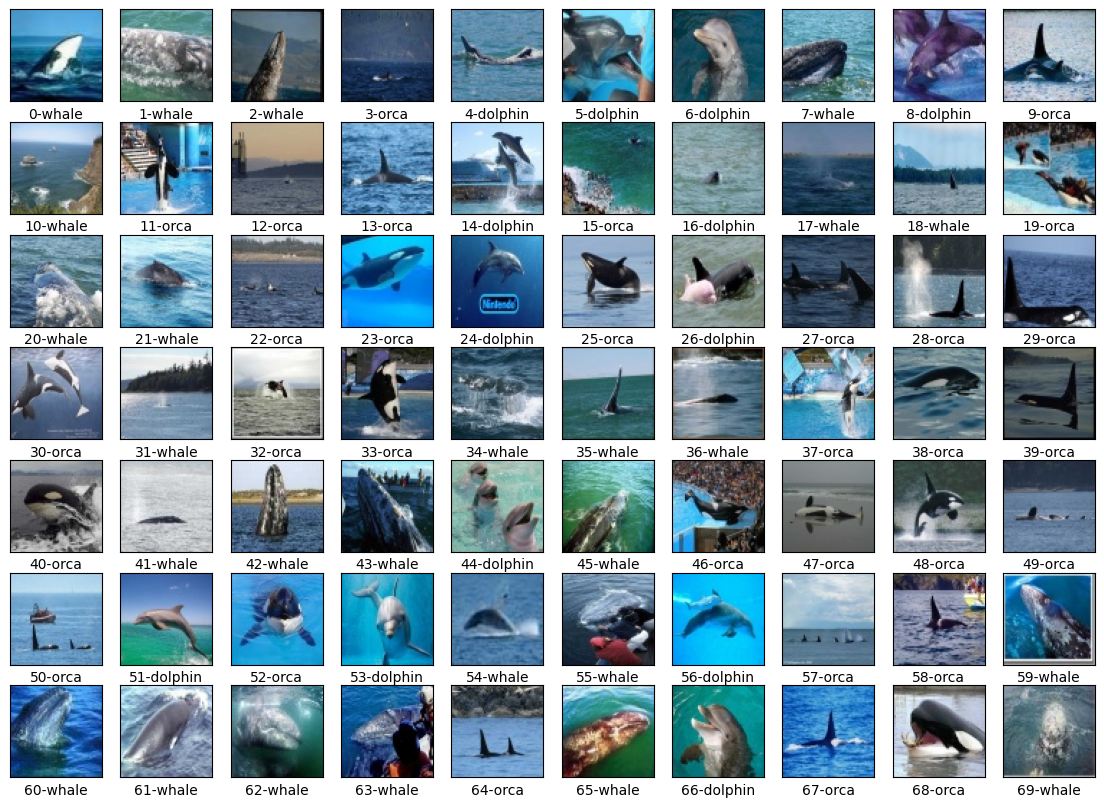

In [ ]:
plt.figure(figsize=(14, 10))
for i in range(7*10):
    plt.subplot(7, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(f'{i}-{class_names[y_train[i]]}')
plt.show()

## 2. Introduction to convolutions: edge detection through Sobel filters

In this chapter, we delve into the basics of convolutions and showcase their power in feature extraction using simple filters, specifically the Sobel operators.

### Convolutions

Convolutional operations involve sliding a filter (also known as a kernel or mask) over an image, computing the element-wise product of the filter and the image pixels within its receptive field, and then summing these products. This process enables the extraction of various features like edges, textures, and patterns.

### Sobel Filters for Edge Detection

Sobel operators are widely used for edge detection, a crucial step in image processing and computer vision tasks. These filters consist of two 3x3 matrices, one for detecting horizontal changes and the other for vertical changes. By applying these filters through convolution, we can emphasize edges in different orientations.

### Loading and Preprocessing the Image

Before we begin, we need to load an image from our dataset and we convert it to grayscale for convenience.

In [ ]:
# You can choose the image of your preference based on the grid of images above
n_image = 0

In [ ]:
image = X_train[n_image]
image_grayscale = np.mean(X_train[n_image], axis=-1)

In [ ]:
def apply_filter(image, kernel):
    # Apply the filter using scipy's convolve2d
    filtered = convolve2d(image, kernel, mode='same', boundary='symm')
    return convolve2d(image, kernel, mode='same', boundary='symm')

Before applying Sobel operators to an image, let's take a closer look at the two 3x3 filters used for horizontal (Sobel-X) and vertical (Sobel-Y) edge detection. These kernels play a crucial role in highlighting changes in intensity in their respective directions.

In [ ]:
# Define the 3x3 vertical and horizontal filters
vertical_kernel = np.array([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]])
horizontal_kernel = np.array([[1, 2, 1],
                              [0, 0, 0],
                              [-1, -2, -1]])

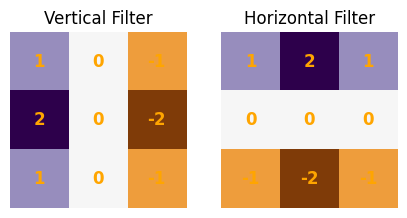

In [ ]:
# Visualize these filters
fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].imshow(vertical_kernel, cmap='PuOr')
ax[0].set_title('Vertical Filter')
ax[0].axis('off')
for i in range(3):
    for j in range(3):
        ax[0].text(j, i, str(vertical_kernel[i, j]), color='orange',
                    ha='center', va='center', fontsize=12, fontweight='bold')
ax[1].imshow(horizontal_kernel, cmap='PuOr')
ax[1].set_title('Horizontal Filter')
ax[1].axis('off')
for i in range(3):
    for j in range(3):
        ax[1].text(j, i, str(horizontal_kernel[i, j]), color='orange',
                    ha='center', va='center', fontsize=12, fontweight='bold')

Apply the filter to the image using scipy's `convolve2d` function:

In [ ]:
vertical_filtered = convolve2d(image_grayscale, vertical_kernel,
                               mode='same', boundary='symm')
horizontal_filtered = convolve2d(image_grayscale, horizontal_kernel,
                                 mode='same', boundary='symm')

Visualize the results!

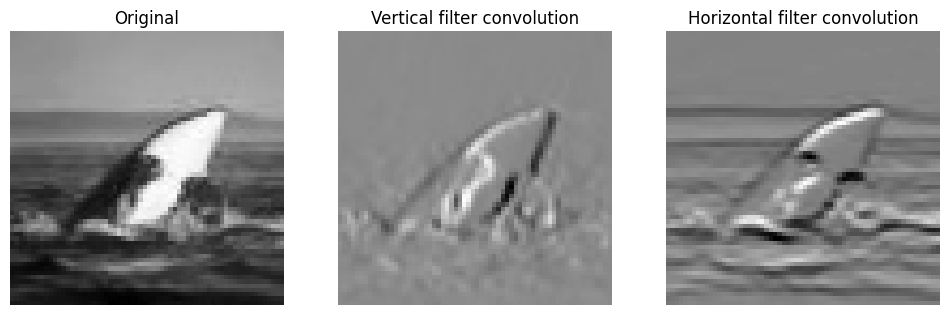

In [ ]:
# Display the original image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(image_grayscale, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')

# Display the result of the vertical Sobel filter convolution
ax[1].imshow(vertical_filtered, cmap='gray')
ax[1].set_title('Vertical filter convolution')
ax[1].axis('off')

# Display the result of the horizontal Sobel filter convolution
ax[2].imshow(horizontal_filtered, cmap='gray')
ax[2].set_title('Horizontal filter convolution')
ax[2].axis('off')
plt.show()

The two-dimensional rate of change of pixel intensity across an image can be derived by combining the effects of vertical and horizontal changes in intensity. The resulting image provides a visual map of edges and transitions in the image:

In [ ]:
edge_image = np.sqrt(vertical_filtered**2 + horizontal_filtered**2)

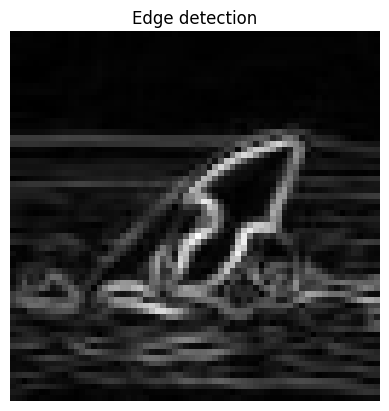

In [ ]:
plt.imshow(edge_image, cmap='gray')
plt.title('Edge detection')
plt.axis('off')
plt.show()

The strength of deep neural networks derive from their ability to automatically find useful features from the raw data.

In image analysis, features represent visually distinctive attributes. For instance, recognizing a dolphin involves detecting the triangular shape of its dorsal fin. It turns out that it is usually easier to detect this from the edges rather than relying on raw pixels.

We have seen in this chapter how efficiently edge detection can be performed through edge detection. We hope this gives you some insights on why convolutions are useful in image processing.

## 3. Visualize the `MaxPooling` operation

In Convolutional Neural Networks (CNNs), MaxPooling is a crucial operation employed for downsampling feature maps. MaxPooling is typically applied after convolutional layers and activation functions.

**Key Functions of MaxPooling**:

1. **Downsampling:** MaxPooling reduces the size of the feature maps, leading to a more compact representation of the input data.

2. **Translation Invariance:** By retaining only the maximum values within small regions, MaxPooling introduces a degree of translation invariance, making the network more robust to slight shifts in input patterns.

3. **Increase the receptive field:** 3 by 3 pixels covers a larger proportion of the image if this image has 32 $\times$ 32 pixels than if it has 64 $\times$ 64. In a convolutional neural network, each MaxPooling layer allows the model to process increasingly larger proportions of the input image. This hierarchical approach facilitates the extraction of hierarchical features, enhancing the network's ability to capture both local details and broader contextual information in the data.

Let's visualize the effect of a MaxPooling operation on our edge detection feature!

In [ ]:
feature_map = edge_image
feature_map.shape

(64, 64)

**Hard-code max pooling** to reduce the dimensions from $(64, 64)$ to $(32, 32)$. This involves identifying, within each 2 by 2 pixels box, the pixel with the highest value.

In [ ]:
pooled_feature_map = np.zeros((feature_map.shape[0] // 2, feature_map.shape[1] // 2))
for i in range(0, feature_map.shape[0] - 1, 2):
    for j in range(0, feature_map.shape[1] - 1, 2):
        pooled_feature_map[i // 2, j // 2] = np.max(feature_map[i:i+2, j:j+2])

In [ ]:
pooled_feature_map.shape

(32, 32)

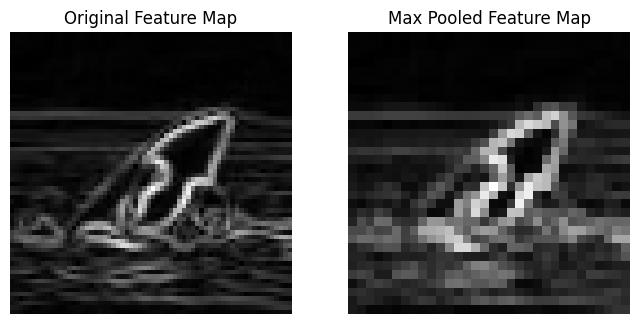

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(feature_map, cmap='gray', interpolation='none')
ax[0].set_title('Original Feature Map')
ax[0].axis('off')
ax[1].imshow(pooled_feature_map, cmap='gray', interpolation='none')
ax[1].set_title('Max Pooled Feature Map')
ax[1].axis('off')
plt.show()

## 4. Convolutional neural network


Building upon our understanding of convolutions for edge detection and the significance of MaxPooling in downsampling, we now embark on the exploration of Convolutional Neural Networks (CNNs) - sophisticated architectures designed for image classification and feature extraction.

### Anatomy of CNNs:

CNNs are characterized by a sequence of convolutional and MaxPooling layers, strategically arranged. This architectural design facilitates the extraction of intricate visual features, progressively revealing more abstract representations.

#### Convolutional Layers:
   - **Feature Extraction:** Conv2D layers are the cornerstone, systematically applying filters to the input images. These filters, akin to our previously explored vertical and horizontal kernels extract visual features in an efficient way. The parameters / weights that the model learns through training are the values of the filters.
   - **Abstraction Levels:** As we move through successive convolutional layers, the network captures high-level features with an increasing level of abstraction. This process allows the CNN to learn complex visual patterns and structures.

#### MaxPooling Layers:
   - **Receptive Field Expansion:** MaxPooling layers contribute to downsampling spatial dimensions, enabling the network to process larger portions of the input. This leads to an increased receptive field, facilitating the understanding of contextual relationships within the image.

#### Flattening and Dense Layers:
   - **Transition to MLP-like Structure:** Following the feature extraction process, the flattened output is fed into dense layers, resembling the structure of Multi-Layer Perceptrons (MLPs) from Module 4.
   - **Class Relationship:** These dense layers analyze the relationships between the extracted visual features and the predefined classes, allowing the CNN to make predictions.


In [ ]:
# Define a convolutional neural network
CNN_model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

The `model.summary()` output offers a comprehensive view of the Convolutional Neural Network (CNN) architecture, revealing the hierarchical treatment of the input data. Let's delve into the breakdown:

In [ ]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)         0

The "Output Shape" column delineates the dimensions of the output after each layer's operation. Note the systematic reduction in spatial resolution (62x62 ➔ 31x31 ➔ 14x14 ➔ 6x6) within a hierarchical structure, accompanied by an augmentation in the number of features. There is a transition from raw and fine data to high-level and coarse visual information, from maps of simple patterns to the detection complex shapes.

The "flatten" layer plays a pivotal role by reshaping the 256 two-dimensional feature maps into a compressed 1D array containing 9216 elements.  These 9216 elements are high-level visual features, each corresponding to distinct regions in the image. The following dense layer comprehensively processes the entire image, combining insights from diverse parts to form a holistic representation. The ultimate dense layer establishes the crucial link between the aggregated global features and the classes.

The rest is the same as in module 4, we compile the model, indicating the `optimizer`, the `learning_rate` and the `loss` function.

In [ ]:
CNN_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

Still as in module 4, we fit the model using `keras` magical function `.fit`, and specifying the `batch_size`.

In [ ]:
CNN_history = CNN_model.fit(X_train, y_train,
                            batch_size=16, epochs=20,
                            validation_data=(X_test, y_test))

Epoch 1/20
131/131 [==============================] - 18s 14ms/step - loss: 1.0425 - accuracy: 0.4668 - val_loss: 0.9802 - val_accuracy: 0.5296
Epoch 2/20
131/131 [==============================] - 1s 8ms/step - loss: 0.9442 - accuracy: 0.5518 - val_loss: 0.9011 - val_accuracy: 0.5500
Epoch 3/20
131/131 [==============================] - 1s 9ms/step - loss: 0.8811 - accuracy: 0.6030 - val_loss: 0.8453 - val_accuracy: 0.6450
Epoch 4/20
131/131 [==============================] - 1s 9ms/step - loss: 0.8365 - accuracy: 0.6302 - val_loss: 0.8143 - val_accuracy: 0.6392
Epoch 5/20
131/131 [==============================] - 1s 8ms/step - loss: 0.8125 - accuracy: 0.6369 - val_loss: 0.8292 - val_accuracy: 0.6305
Epoch 6/20
131/131 [==============================] - 1s 9ms/step - loss: 0.7784 - accuracy: 0.6660 - val_loss: 0.8278 - val_accuracy: 0.6392
Epoch 7/20
131/131 [==============================] - 1s 10ms/step - loss: 0.7570 - accuracy: 0.6718 - val_loss: 0.8372 - val_accuracy: 0.6547
Epo

Text(0.5, 1.0, 'Learning curves')

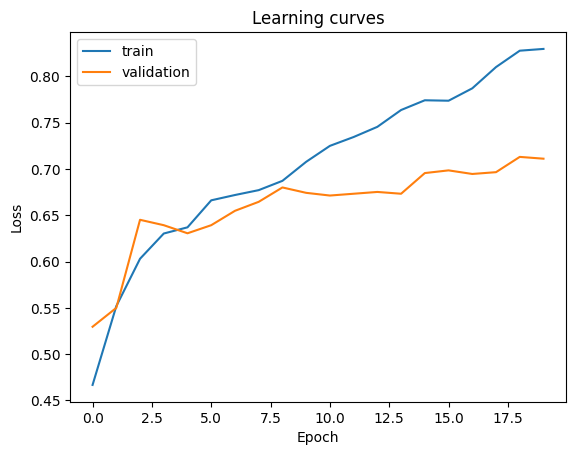

In [ ]:
plt.plot(CNN_history.history['accuracy'], label='train')
plt.plot(CNN_history.history['val_accuracy'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Learning curves')

We now have a trained model (even though it may not have converged and is probably overfitting at this stage).

Let's start making predictions on the test dataset.

## 5. Model performance

In [ ]:
CNN_predictions = CNN_model.predict(X_test)

33/33 [==============================] - 0s 3ms/step


**Run the following block multiple times to check the results on various images**

<ipython-input-60-34972ab4511e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(class_names, rotation=45, ha='right')


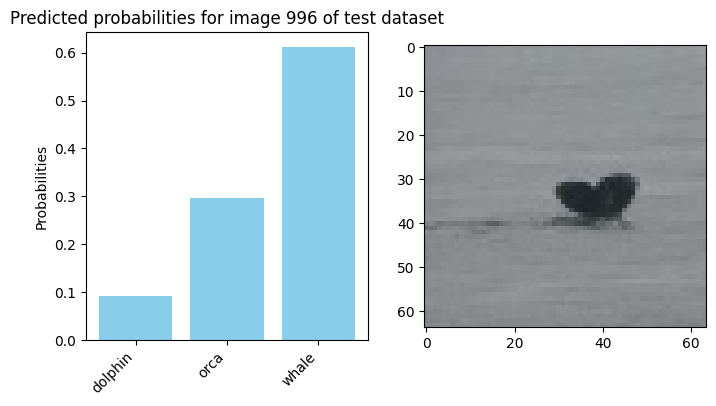

In [ ]:
# pick one instance in the test dataset
random_index = np.random.randint(len(X_test))

# display probabilities
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].bar(class_names, CNN_predictions[random_index], color='skyblue')
ax[0].set_title(f'Predicted probabilities for image {random_index} of test dataset')
ax[0].set_ylabel('Probabilities')
ax[0].set_xticklabels(class_names, rotation=45, ha='right')

# show image
ax[1].imshow(X_test[random_index])
plt.show()

In [ ]:
# Predict classes from probabilities
CNN_classes = np.argmax(CNN_predictions, axis=-1)

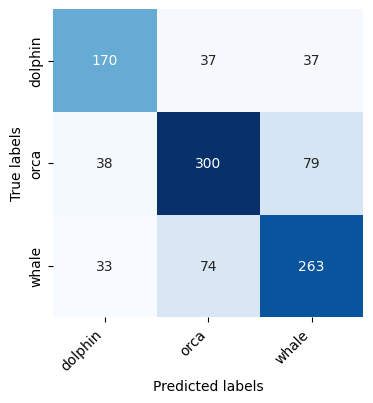

In [ ]:
# display confusion matrix
cm_CNN = confusion_matrix(y_test, CNN_classes)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm_CNN, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

#### **Optional exercise**: Compare the performance of your CNN with a multi-layer perceptron (similar to module 4) - are CNNs that superior to MLPs?

In [ ]:
# your code

## 6. Transfer learning

Instead of training a model from scratch by initializing it with random weights, it might be better to efficient utilization of knowledge acquired from one task to enhance performance for another.

In this paradigm, we leverage a pre-trained neural network, trained on the large ImageNet dataset, and tailor it to address our specific problem of classifying marine life.

#### 6.1. Load Pre-trained Model:

We begin by importing a pre-trained model, in this case, `VGG16`, without its top layers (`include_top=False`). That is because `VGG16` has been trained on larger images (size: `224, 224, 3`). `VGG16` is a deep convolutional network trained on the large dataset ImageNet to recongnize 1,000 different classes. It is thus able to extract complex visual information and that will be useful for our task.

In [ ]:
base_model = keras.applications.VGG16(weights='imagenet', include_top=False,
                                      input_shape=(64, 64, 3))

58889256/58889256 [==============================] - 0s 0us/step


Let's see how it looks like:

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# The last layer of VGG 16 outputs 512 high-level feature maps of size (2, 2)
VGG_16_features = base_model.layers[-1].output

#### 6.2. Load Pre-trained Model:Add Custom Classification Layers:

Next, we append custom classification layers to the pre-trained model. This involves creating a new softmax layer tailored to the number of classes in our specific problem (here: 3). But before this, we need to flatten the `(2, 2, 512)` shape of the last layer of our base model to a list of `(2048)` features.

In [ ]:
# Flatten and dense layer
flattened_features = Flatten()(VGG_16_features)
probabilities = Dense(3, activation='softmax')(flattened_features)

Stitch the two parts of the model together:

In [ ]:
# once again, it is THAT simple to combine them
model = Model(base_model.input, probabilities)

#### 6.3. Freeze Pre-trained Layers:
To preserve the knowledge embedded in the pre-trained model, we freeze its layers: we prevent them from being updated during training. At first, we will only update the last layer which we added ourself and that, for now, has random weights.

In [ ]:
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# see what changed compared to base_model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

*Look at the number number non-trainable and trainable parameters*

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
66/66 [==============================] - 4s 44ms/step - loss: 1.1202 - accuracy: 0.3942 - val_loss: 1.0502 - val_accuracy: 0.4151
Epoch 2/10
66/66 [==============================] - 2s 25ms/step - loss: 0.9913 - accuracy: 0.4692 - val_loss: 0.9588 - val_accuracy: 0.5024
Epoch 3/10
66/66 [==============================] - 2s 25ms/step - loss: 0.9159 - accuracy: 0.5647 - val_loss: 0.8994 - val_accuracy: 0.5752
Epoch 4/10
66/66 [==============================] - 1s 23ms/step - loss: 0.8650 - accuracy: 0.6097 - val_loss: 0.8585 - val_accuracy: 0.6101
Epoch 5/10
66/66 [==============================] - 2s 25ms/step - loss: 0.8265 - accuracy: 0.6426 - val_loss: 0.8300 - val_accuracy: 0.6343
Epoch 6/10
66/66 [==============================] - 2s 25ms/step - loss: 0.7987 - accuracy: 0.6565 - val_loss: 0.8083 - val_accuracy: 0.6382
Epoch 7/10
66/66 [==============================] - 1s 22ms/step - loss: 0.7768 - accuracy: 0.6617 - val_loss: 0.7902 - val_accuracy: 0.6469
Epoch 8/10
66

####6.4. Fine-tune the model
For further refinement, we unlock all layers in the pre-trained model and fine-tune the entire network with a small learning rate and high batch size.

In [ ]:
base_model.trainable = True

In [ ]:
# verify that all the parameters are now trainable
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# we set a low learning rate to avoid unlearning what the model has learnt
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Exercise**: Fine-tune the model - do you manage to outperform the previous CNN model?

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=128, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
17/17 [==============================] - 13s 284ms/step - loss: 0.6612 - accuracy: 0.7124 - val_loss: 0.6124 - val_accuracy: 0.7507
Epoch 2/10
17/17 [==============================] - 3s 152ms/step - loss: 0.5067 - accuracy: 0.7917 - val_loss: 0.5562 - val_accuracy: 0.7711
Epoch 3/10
17/17 [==============================] - 3s 174ms/step - loss: 0.4074 - accuracy: 0.8318 - val_loss: 0.5095 - val_accuracy: 0.7973
Epoch 4/10
17/17 [==============================] - 3s 154ms/step - loss: 0.3232 - accuracy: 0.8700 - val_loss: 0.4911 - val_accuracy: 0.8157
Epoch 5/10
17/17 [==============================] - 3s 154ms/step - loss: 0.2477 - accuracy: 0.9183 - val_loss: 0.4764 - val_accuracy: 0.8264
Epoch 6/10
17/17 [==============================] - 3s 173ms/step - loss: 0.1935 - accuracy: 0.9379 - val_loss: 0.5245 - val_accuracy: 0.8138
Epoch 7/10
17/17 [==============================] - 3s 180ms/step - loss: 0.1563 - accuracy: 0.9498 - val_loss: 0.5055 - val_accuracy: 0.8157
Epoch

In [ ]:
transfer_predictions = model.predict(X_test)
transfer_classes = np.argmax(transfer_predictions, axis=-1)

33/33 [==============================] - 1s 20ms/step


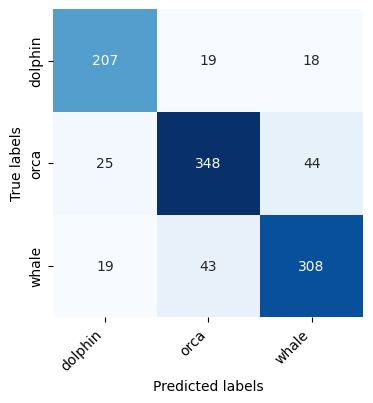

In [ ]:
# display confusion matrix
cm_transfer = confusion_matrix(y_test, transfer_classes)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

## 7. Optional content: Image augmentation

At this stage both models are clearly overfitting the data, it is common for neural networks as they are extremely complex. We could reduce this effect by using *data augmentation*, artificially increase the number of images in our training dataset.

`Albumentations` is great user-friendly library to perform various type of transformation on your images: https://albumentations.ai/, but we can also use Keras's `ImageDataGenerator`

#### Introduction to image augmentation

In [ ]:
# Data augmentation function
from keras.preprocessing.image import ImageDataGenerator

# Define random transformations
datagen = ImageDataGenerator(
    rescale=1.,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Choose an image as an example
n_image = np.random.randint(len(X_test))
img = np.expand_dims(X_test[n_image], axis=0)

In [ ]:
# Generate 3 augmented images
augmented_images = []
for batch in datagen.flow(img, batch_size=1):
    augmented_images.append(batch[0])
    if len(augmented_images) >= 3:
        break

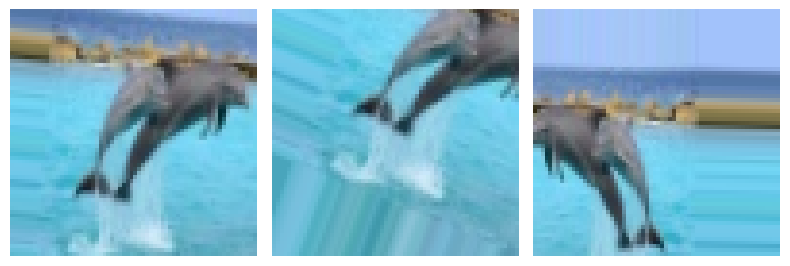

In [ ]:
# Create a 3 by 3 grid for visualization
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes = axes.flatten()

# Display each augmented image
for img, ax in zip(augmented_images, axes):
    ax.imshow(img.squeeze())  # Assuming img is in (height, width, channels) format
    ax.axis('off')
plt.tight_layout()
plt.show()

#### **Exercise**: training a model using a `ImageDataGenerator`

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
batch_size = 64
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    steps_per_epoch=len(X_train)//batch_size, epochs=10)

Epoch 1/10
32/32 [==============================] - 11s 235ms/step - loss: 0.6592 - accuracy: 0.7486 - val_loss: 0.5583 - val_accuracy: 0.7536
Epoch 2/10
32/32 [==============================] - 10s 300ms/step - loss: 0.5277 - accuracy: 0.7822 - val_loss: 0.5386 - val_accuracy: 0.8041
Epoch 3/10
32/32 [==============================] - 8s 245ms/step - loss: 0.5027 - accuracy: 0.7935 - val_loss: 0.4504 - val_accuracy: 0.8371
Epoch 4/10
32/32 [==============================] - 6s 191ms/step - loss: 0.4269 - accuracy: 0.8290 - val_loss: 0.4697 - val_accuracy: 0.8303
Epoch 5/10
32/32 [==============================] - 4s 123ms/step - loss: 0.4278 - accuracy: 0.8314 - val_loss: 0.4656 - val_accuracy: 0.8283
Epoch 6/10
32/32 [==============================] - 5s 165ms/step - loss: 0.4285 - accuracy: 0.8221 - val_loss: 0.4843 - val_accuracy: 0.8235
Epoch 7/10
32/32 [==============================] - 4s 126ms/step - loss: 0.4009 - accuracy: 0.8310 - val_loss: 0.4550 - val_accuracy: 0.8390
Epoc

The accuracy on the training dataset is much lower than it was before.The model is not able to overfit the data as it used to without image augmentation.
Here, for our CNN, we have much more parameters than we have training samples (overparameterized). The model could in principle fit the training dataset perfectly by simply memorizing the training labels. The goal of data augmentation is to prevent the model from memorizing the input images and thus to force it to learn useful features.

## 8. Saliency Maps: Interpreting Model Predictions

In the realm of neural networks, particularly in image classification tasks, the generation of saliency maps provides valuable insights into the model's decision-making process. A saliency map highlights the regions in an input image that significantly contribute to the model's prediction for a specific class. The concept revolves around the fundamental question: "For each input pixel, how much would the prediction change if this pixel was altered?"

#### **Practical Implementation**:

The saliency map generation involves the following steps:

**Model Prediction:** Obtain the model's predicted class for the input image.

**Gradient Calculation:** Employ backpropagation to compute the gradient of the loss with respect to the input pixels.

**Absolute Values and Normalization:** Take the absolute values of the gradients and normalize them to ensure consistency.

**Visualization:** Overlay the normalized gradient values on the original image, producing a visual representation of pixel importance.

Saliency maps offer a powerful means to interpret and validate neural network decisions, fostering transparency in the decision-making process and aiding model debugging and improvement.


In [ ]:
# Choose an image randomly in the dataset
n_image = np.random.randint(len(X_test))
image = np.expand_dims(X_test[n_image], axis=0)

In [ ]:
# Get the model's predicted class index for this image
predicted_class = np.argmax(model.predict(image)[0])
print(f'Predicted class: {class_names[predicted_class]}')

1/1 [==============================] - 0s 29ms/step
Predicted class: dolphin


The following block is quite technical, it is deriving the gradient of the predicted score with respect to the input image: `tape.gradient(predicted_score, input_tensor)`

In [ ]:
# Calculate gradients with respect to the input image for the predicted class
input_tensor = tf.convert_to_tensor(image)
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    predicted_score = prediction[0, predicted_class]
gradients = tape.gradient(predicted_score, input_tensor).numpy()
gradients.shape

(1, 64, 64, 3)

In [ ]:
# Calculate the absolute values of gradients and normalize
gradients = tf.abs(gradients)
max_grad = tf.reduce_max(gradients)
if max_grad != 0:
    gradients /= max_grad

# Convert gradients to a grayscale image
grayscale = tf.image.rgb_to_grayscale(gradients)
saliency_map = tf.squeeze(grayscale).numpy()

It is then quite useful to smooth the resulting saliency map to highlight regions of the input image instead of individual pixels.

In [ ]:
smoothed_saliency_map = gaussian_filter(saliency_map, sigma=2)

Tada! We can now overlay the saliency map over the input image:

(-0.5, 63.5, 63.5, -0.5)

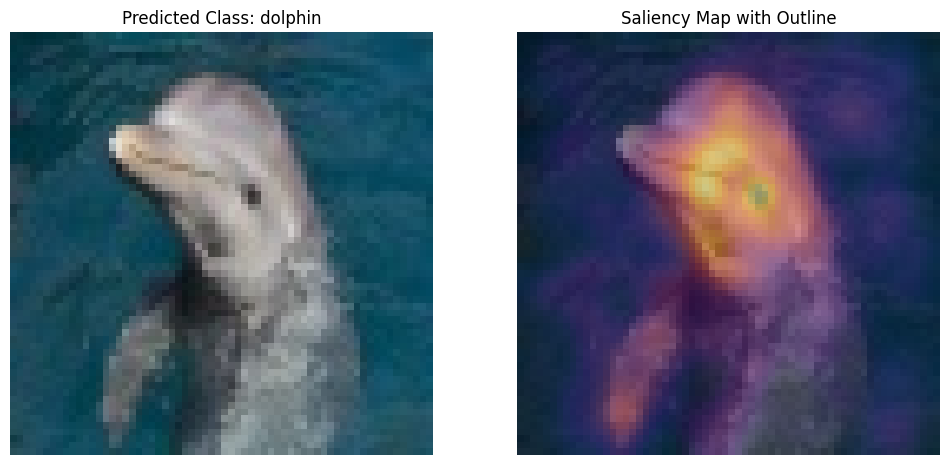

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.axis('off')
plt.title(f'Predicted Class: {class_names[predicted_class]}')
plt.subplot(1, 2, 2)
plt.imshow(image[0])
plt.imshow(smoothed_saliency_map, cmap='inferno', alpha=0.5)
plt.title('Saliency Map with Outline')
plt.axis('off')

You can play with it, and change the example image (`n_image`) to see where the CNN model looks to make its predictions.

## **THE END**